## BMI Standard Deviation 

The purpose of this notebook is to pull in the BMI standard deviation values and then create a function that replaces values which are over a certain limit

### Pull in the 2019 BMI standard deviation values 

Note that the 2021 values are not terribly different and this code should be able to be used with just changing to release_id 9

In [1]:
import pandas as pd, numpy as np, os
from db_queries import get_ids, get_outputs, get_location_metadata, get_population, get_covariate_estimates
from get_draws.api import get_draws
import matplotlib.pyplot as plt
import random

In [2]:
bmi_std = get_draws(release_id=6,
         year_id=2019,
         sex_id=[1,2],
         location_id=523,
         age_group_id=[10,11,12,13,14,15,16,17,18,19,20,30,31,32],
         gbd_id_type='modelable_entity_id',
         gbd_id=18706,
         source='epi')

In [3]:
data = bmi_std.set_index(['sex_id','modelable_entity_id','age_group_id'])
data = (data[[c for c in data.columns if 'draw' in c]].stack().reset_index()
        .rename(columns={'level_3':'draw',0:'value'}))
data = (data.pivot_table(index=['sex_id','age_group_id','draw'], columns='modelable_entity_id', values='value')
        .reset_index())
data = data.rename(columns={18706:'standard_deviation'})
data.head()

modelable_entity_id,sex_id,age_group_id,draw,standard_deviation
0,1,10,draw_0,9.591207
1,1,10,draw_1,9.922810
2,1,10,draw_10,5.695761
3,1,10,draw_100,9.091147
4,1,10,draw_101,3.859586


Text(0.5, 1.0, 'Standard Deviation by Age Group')

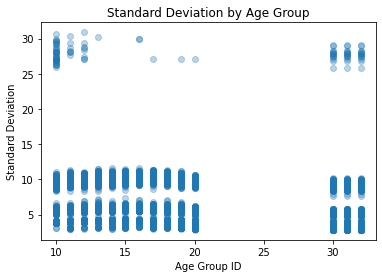

In [4]:
plt.scatter(data.age_group_id, data.standard_deviation, alpha=0.3)
plt.xlabel("Age Group ID")
plt.ylabel("Standard Deviation")
plt.title("Standard Deviation by Age Group") 

Text(0, 0.5, 'Counts')

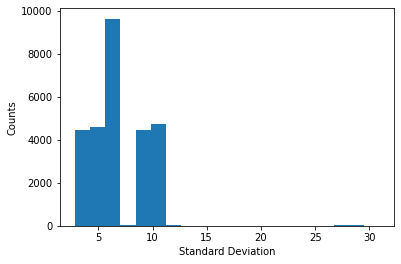

In [5]:
plt.hist(data.standard_deviation, bins=20)
plt.xlabel("Standard Deviation")
plt.ylabel("Counts")

As we can see in the graphs above, there are very few values that are very high and there is a significant gap without any values between ~15 and ~25. Therefore, we will start by removing all standard deviations over 15 and replacing them with the average of the other standard deviations.

### Replacing Value over 15

Start by doing this for a single age/sex group

In [6]:
bmi_std_2_10 = data.loc[(data.sex_id == 2) & (data.age_group_id == 10)]
bmi_std_2_10_reasonable = bmi_std_2_10.standard_deviation.loc[bmi_std_2_10.standard_deviation < 15]
len(bmi_std_2_10_reasonable)

#So there are 965 of the samples that fall below 15. That means 35 are above 15. So we need to replace the other 35

965

In [7]:
y = random.sample(bmi_std_2_10_reasonable.tolist(),50)
avg = np.mean(y)
avg

8.944417697692648

In [8]:
for i in range(len(bmi_std_2_10)):
    if bmi_std_2_10.standard_deviation.iloc[i] > 15: 
        y = random.sample(bmi_std_2_10_reasonable.tolist(),50)
        avg = np.mean(y)
        bmi_std_2_10.standard_deviation.iloc[i] = avg 

Text(0, 0.5, 'Counts')

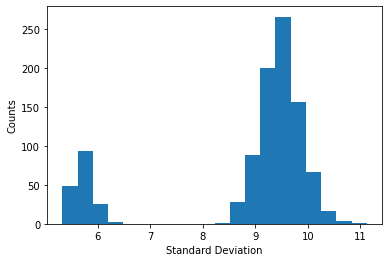

In [9]:
plt.hist(bmi_std_2_10.standard_deviation, bins=20)
plt.xlabel("Standard Deviation")
plt.ylabel("Counts")

This seemed to work! 

### Generalizing the above into something that works for the full dataset

In [24]:
new_data = pd.DataFrame()
for i in range(3):
    for j in range(data.age_group_id.nunique()):
        age_group_id = data.age_group_id.unique()[j]
        data_current = data.loc[(data.sex_id == i) & (data.age_group_id == age_group_id)]
        data_current_reasonable = data_current.standard_deviation.loc[data_current.standard_deviation < 15]
        for k in range(len(data_current)):
            if data_current.standard_deviation.iloc[k] > 15: 
                y = random.sample(data_current_reasonable.tolist(),50)
                avg = np.mean(y)
                data_current.standard_deviation.iloc[k] = avg 
        new_data = pd.concat([new_data,data_current])

Text(0.5, 1.0, 'Standard Deviation by Age Group')

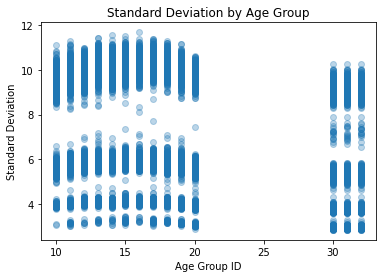

In [11]:
plt.scatter(new_data.age_group_id, new_data.standard_deviation, alpha=0.3)
plt.xlabel("Age Group ID")
plt.ylabel("Standard Deviation")
plt.title("Standard Deviation by Age Group") 

Text(0, 0.5, 'Counts')

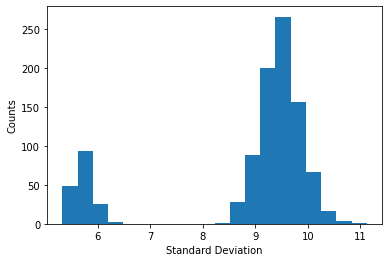

In [12]:
plt.hist(bmi_std_2_10.standard_deviation, bins=20)
plt.xlabel("Standard Deviation")
plt.ylabel("Counts")

In [13]:
len(new_data.loc[new_data.standard_deviation > 8]) / len(new_data.standard_deviation)

0.3309285714285714

In [14]:
len(new_data.loc[new_data.standard_deviation < 4]) / len(new_data.standard_deviation)

0.10617857142857143

In [25]:
len(new_data.loc[(new_data.standard_deviation < 4) & (new_data.age_group_id == 10)]) / len(new_data.loc[(new_data.age_group_id == 10)])

0.022

While this did fix the issue with the more egregious standard deviations, the distribution still looks quite odd. This will hopefully be fixed in later rounds of GBD, but for now we can use this as a temporary fix.  

### Converting back to wide format and saving csv

In [15]:
data_final = pd.pivot(new_data, index=['sex_id','age_group_id'], columns='draw', values='standard_deviation')
data_final.head()

draw                    draw_0     draw_1    draw_10  draw_100  draw_101  \
sex_id age_group_id                                                        
1      10             9.591207   9.922810   5.695761  9.091147  3.859586   
       11            10.256039  10.391654  10.105663  5.700073  3.966391   
       12            10.389089  10.286025   6.292133  4.231660  5.711935   
       13            10.100829  10.286053   6.276364  5.894123  4.228448   
       14            10.475955  11.048295   6.056815  5.826590  5.796687   

draw                  draw_102   draw_103   draw_104  draw_105   draw_106  \
sex_id age_group_id                                                         
1      10             9.433036   9.533512   5.579364  5.448073   9.292075   
       11            10.399353  10.086447   5.775341  5.593524   6.105253   
       12            10.261169   5.977911  10.238705  5.807984   9.972524   
       13            10.519777  10.105449  10.327860  5.824145   6.360334   
       14             9.923691   6.129840  10.229780  5.977795  10.021224   

draw                 ...  draw_990  draw_991  draw_992  draw_993  draw_994  \
sex_id age_group_id  ...                                                     
1      10            ...  9.300838  5.612157  5.413803  5.555912  5.714656   
       11            ...  5.628805  5.591587  4.130237  4.033986  5.631593   
       12            ...  5.775050  5.914890  4.117794  5.614308  4.155514   
       13            ...  5.786042  5.713011  5.798132  5.679333  3.127180   
       14            ...  5.954685  5.910142  5.897804  5.871997  5.672783   

draw                 draw_995  draw_996  draw_997  draw_998   draw_999  
sex_id age_group_id                                                     
1      10            3.849423  5.560263  5.732402  5.201153   5.737831  
       11            5.566593  5.790419  5.859199  3.104723   5.719223  
       12            4.070004  4.062159  9.906982  5.691700  10.082787  
       13            4.104800  6.076312  5.941744  5.721536   6.188213  
       14            5.683169  5.824476  5.874003  4.089812  10.040501  

[5 rows x 1000 columns]

In [16]:
data_final.to_csv('/ihme/homes/lutzes/bmi_standard_deviations_adjusted.csv')

### Some V&V Checks

I am checking to make sure that our draws are higher than expected. I found that there are 10% more (43% vs 33%) standard deviations that are >8 and about 1% less that are under 4. 

In [17]:
data_sim_draws = data.loc[data.draw.isin(['draw_29','draw_232','draw_357','draw_394','draw_602','draw_629','draw_650','draw_680','draw_829','draw_946'])]
data_sim_draws.head()

modelable_entity_id,sex_id,age_group_id,draw,standard_deviation
149,1,10,draw_232,9.295992
212,1,10,draw_29,9.400274
287,1,10,draw_357,5.398735
328,1,10,draw_394,5.337914
560,1,10,draw_602,5.534725


Text(0.5, 1.0, 'Standard Deviation by Age Group')

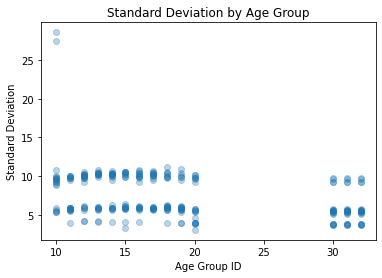

In [18]:
plt.scatter(data_sim_draws.age_group_id, data_sim_draws.standard_deviation, alpha=0.3)
plt.xlabel("Age Group ID")
plt.ylabel("Standard Deviation")
plt.title("Standard Deviation by Age Group") 

In [19]:
new_data = pd.DataFrame()
for i in range(3):
    for j in range(data_sim_draws.age_group_id.nunique()):
        age_group_id = data_sim_draws.age_group_id.unique()[j]
        data_current = data_sim_draws.loc[(data_sim_draws.sex_id == i) & (data_sim_draws.age_group_id == age_group_id)]
        data_current_reasonable = data_current.standard_deviation.loc[data_current.standard_deviation < 15]
        for k in range(len(data_current)):
            if data_current.standard_deviation.iloc[k] > 15: 
                y = random.sample(data_current_reasonable.tolist(),7)
                avg = np.mean(y)
                data_current.standard_deviation.iloc[k] = avg 
        new_data = pd.concat([new_data,data_current])

Text(0.5, 1.0, 'Standard Deviation by Age Group')

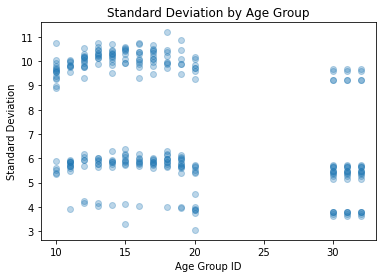

In [20]:
plt.scatter(new_data.age_group_id, new_data.standard_deviation, alpha=0.3)
plt.xlabel("Age Group ID")
plt.ylabel("Standard Deviation")
plt.title("Standard Deviation by Age Group") 

In [21]:
len(new_data.loc[new_data.standard_deviation > 8]) / len(new_data.standard_deviation)

0.4392857142857143

In [22]:
len(new_data.loc[new_data.standard_deviation < 4]) / len(new_data.standard_deviation)

0.09285714285714286

In [23]:
len(new_data.loc[(new_data.standard_deviation < 4) & (new_data.age_group_id == 10)]) / len(new_data.loc[(new_data.age_group_id == 10)])

0.0